# Calculate mean and std of all .tif images in a folder

In [1]:
import os
import numpy as np
import rasterio

tif_folder = 'dataset/NRW_dataset/HR_image'

# Initialize accumulators
channel_sums = None
channel_squared_sums = None
pixel_counts = 0

# Loop over all .tif files
for filename in os.listdir(tif_folder):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        file_path = os.path.join(tif_folder, filename)

        with rasterio.open(file_path) as src:
            img = src.read()  # shape: (channels, height, width)
            img = img.astype(np.float32)

            if channel_sums is None:
                channel_sums = np.zeros(img.shape[0], dtype=np.float64)
                channel_squared_sums = np.zeros(img.shape[0], dtype=np.float64)

            # Compute per-channel sum and sum of squares
            channel_sums += img.reshape(img.shape[0], -1).sum(axis=1)
            channel_squared_sums += (img ** 2).reshape(img.shape[0], -1).sum(axis=1)
            pixel_counts += img.shape[1] * img.shape[2]

# Calculate means and standard deviations
means = channel_sums / pixel_counts
stds = np.sqrt(channel_squared_sums / pixel_counts - means ** 2)

print("Channel Means:", means)
print("Channel Stds:", stds)


Channel Means: [108.79226159 113.64114535 106.78049544]
Channel Stds: [49.52468954 43.63484674 41.11860573]


# Generate manifest file for dataset

In [ ]:
import os
import csv

# Paths to the directories containing images and labels
image_dir = 'dataset/NRW_dataset/HR_image'
lr_label_dir = 'dataset/NRW_dataset/ESA_GLC10_label'

hr_gt_label_dir = 'dataset/NRW_dataset/HR_ground_truth'

# Output CSV file
output_csv = './dataset/CSV_list/NRW.csv'

def extract_key(filename):
    base_name = os.path.splitext(filename)[0]

    key = base_name.removesuffix('_esa')

    return key

try:
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
except FileNotFoundError:
    print(f"ERROR: Image directory not found at '{image_dir}'")
    image_files = []

try:
    lr_label_files = sorted([f for f in os.listdir(lr_label_dir) if f.endswith('.tif')])
except FileNotFoundError:
    print(f"ERROR: LR Label directory not found at '{lr_label_dir}'")
    lr_label_files = []

try:
    hr_gt_label_files = sorted([f for f in os.listdir(hr_gt_label_dir) if f.endswith('.tif')])
except FileNotFoundError:
    print(f"WARNING: HR GT Label directory not found at '{hr_gt_label_dir}'. 'gt_label_fn' column will be empty.")
    hr_gt_label_files = []


image_dict = {extract_key(f): os.path.join(image_dir, f) for f in image_files}
lr_label_dict = {extract_key(f): os.path.join(lr_label_dir, f) for f in lr_label_files}
hr_gt_label_dict = {extract_key(f): os.path.join(hr_gt_label_dir, f) for f in hr_gt_label_files}


master_data = []
for key in image_dict.keys() & lr_label_dict.keys():
    image_path = image_dict[key]
    lr_label_path = lr_label_dict[key]
    hr_gt_label_path = hr_gt_label_dict.get(key, "")

    master_data.append([image_path, lr_label_path, hr_gt_label_path])

with open(output_csv, mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['image_fn', 'label_fn', 'gt_label_fn'])
    writer.writerows(master_data)

num_total_pairs = len(master_data)
num_with_gt = sum(1 for row in master_data if row[2] != "")

print(f"CSV file generated at: {output_csv}")
print(f"Found {num_total_pairs} matching image/LR-label pairs.")
print(f"Of those, {num_with_gt} pairs also have a corresponding HR Ground Truth label.")

# Visualize Ground Truth, LR Label, HR Image and Prediction

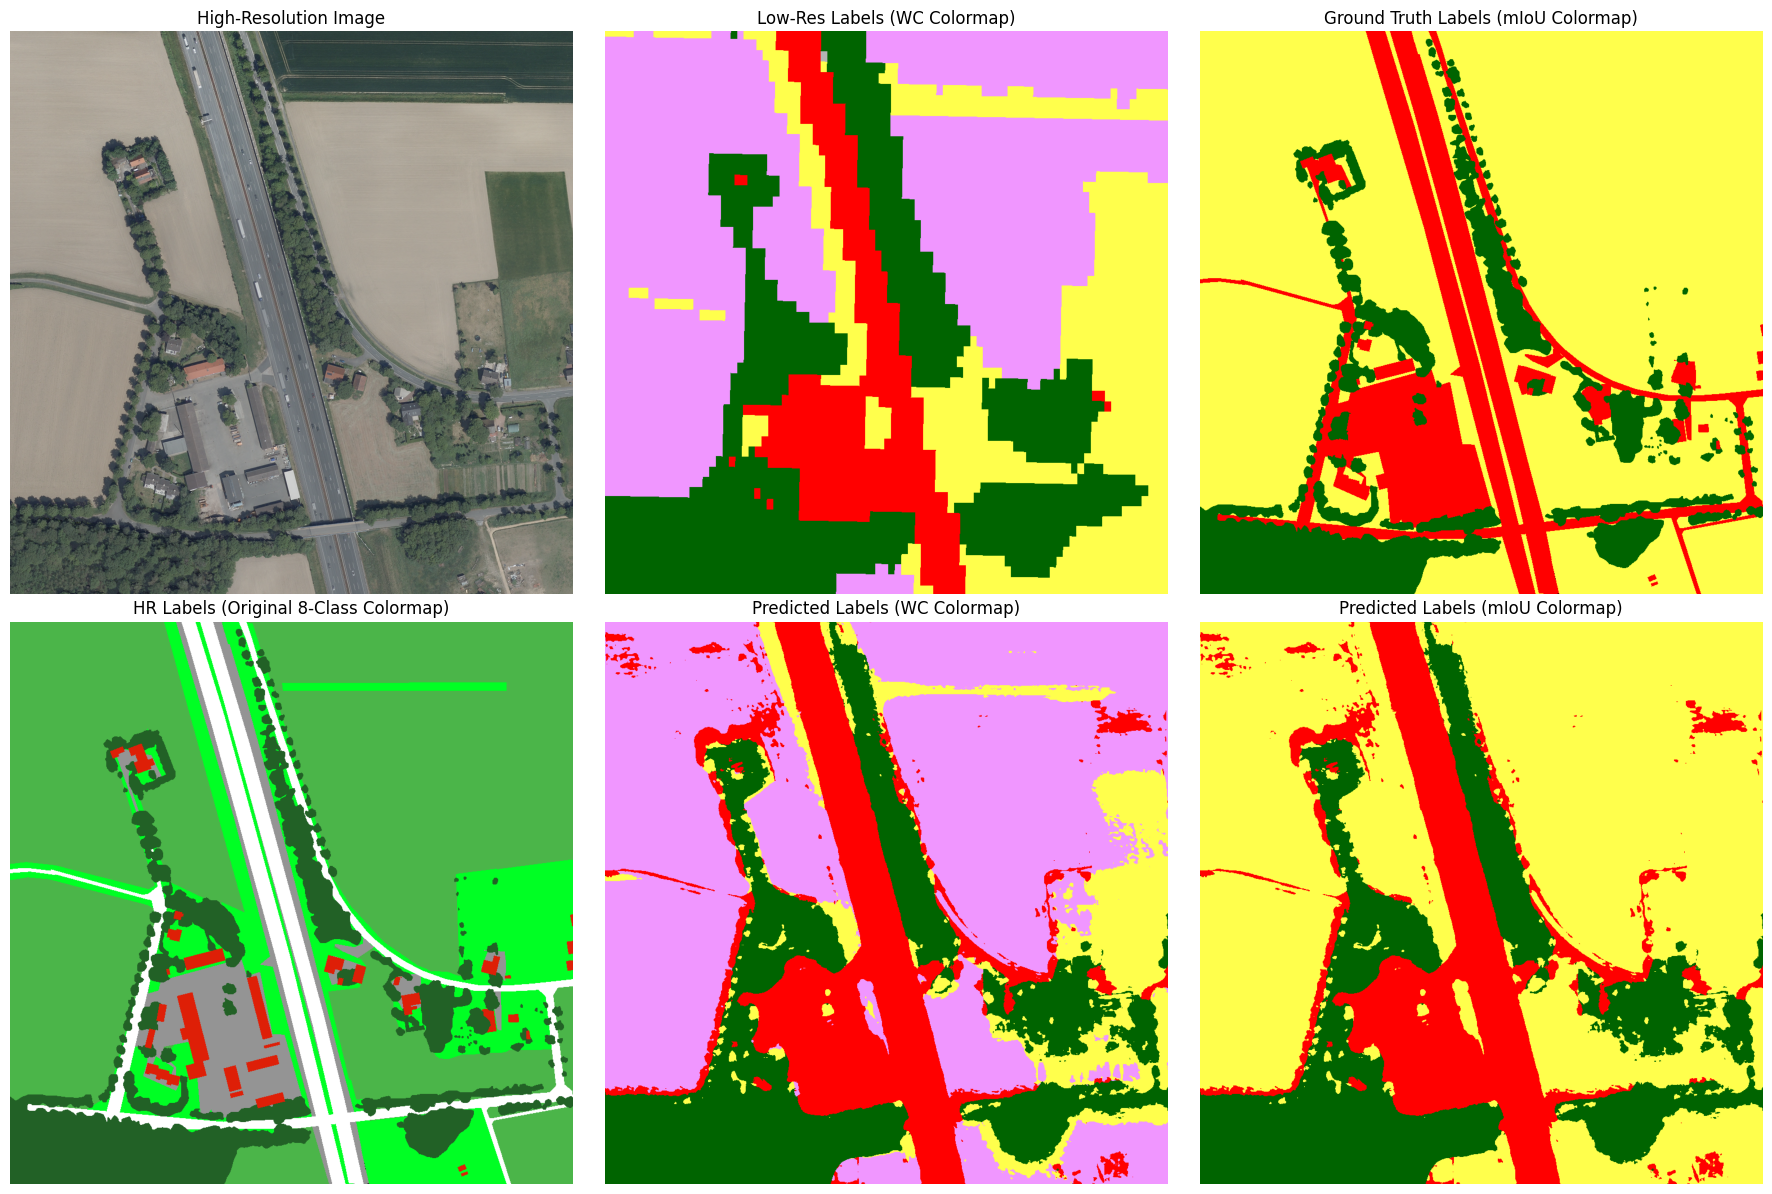

Unique values in predicted_indices (raw): [1 3 4 5]
Unique values in predicted_labels (after PRED_TO_mIoU): [0 1 2]
Unique values in ground_truth_labels (raw): [0 2 3 4 5 7 8]
Unique values in ground_truth_labels (after TARGET_TO_mIoU): [0 1 2 5]


In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt


# Poland
#comparison_file = 'slaskie_15'
#comparison_file = 'wielkopolskie_12'
#comparison_file = 'kujawsko-pomorskie_5'
#comparison_file = 'pomorskie_20'
#comparison_file = 'warminsko-mazurskie_9'
#comparison_file = 'mazowieckie_12'

# Münster
#comparison_file = 'koeln_27'
#comparison_file = 'koeln_53'
comparison_file = 'muenster_12'
#comparison_file = 'muenster_50'
#comparison_file = 'muenster_37'
#comparison_file = 'muenster_27'
#comparison_file = 'duesseldorf_62'
#comparison_file = 'duesseldorf_16'
#comparison_file = 'aachen_46'

# Paths to the images
#predicted_image_path = f'output/128cnnpoland/100/{comparison_file}.tif'
#predicted_image_path = f'output/Testrun_17_07/Poland/2/{comparison_file}.tif'
#predicted_image_path = f'output/Testrun_17_07/NRW/4/{comparison_file}.tif'
#predicted_image_path = f'output/128cnnnrw/100_poland/{comparison_file}.tif'
predicted_image_path = f'output/128cnnnrw/10/{comparison_file}.tif'
#ground_truth_path = f'dataset/Poland_dataset/HR_ground_truth/{comparison_file}.tif'
ground_truth_path = f'dataset/NRW_dataset/HR_ground_truth/{comparison_file}.tif'
#hr_image_path = f'dataset/Poland_dataset/HR_image/{comparison_file}.tif'
hr_image_path = f'dataset/NRW_dataset/HR_image/{comparison_file}.tif' #NRW
#lr_image_path = f'dataset/Poland_dataset/ESA_GLC10_label/{comparison_file}_esa.tif'
lr_image_path = f'dataset/NRW_dataset/ESA_GLC10_label/{comparison_file}.tif' #NRW

# Mapping dictionaries
PRED_TO_mIoU = {
    0: 5, 1: 1, 2: 2, 3: 2, 4: 2, 5: 0, 6: 2, 7: 2, 8: 3, 9: 2, 10: 1, 11: 2
}
LABEL_TO_mIoU = {
    0: 5, 10: 1, 20: 2, 30: 2, 40: 2, 50: 0, 60: 2, 70: 2, 80: 3, 90: 2, 95: 1, 100: 2
}
TARGET_TO_mIoU = {
    0: 5, 1: 2, 2: 2, 3: 0, 4: 0, 5: 1, 6: 3, 7: 2, 8: 0
}
LABEL_TO_PRED = {
    0: 0, 10: 1, 20: 2, 30: 3, 40: 4, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 95: 10, 100: 11
}

# Colormaps
CLASS_COLORMAP_mIoU = {
    0: (255, 0, 0),
    1: (0, 100, 0),
    2: (255, 255, 76),
    3: (0, 100, 200),
    #5: (0, 0, 0)
}
CLASS_COLORMAP_WC_PRED = {
    0: (0, 0, 0), 1: (0, 100, 0), 2: (255, 187, 34), 3: (255, 255, 76),
    4: (240, 150, 255), 5: (255, 0, 0), 6: (180, 180, 180), 7: (240, 240, 240),
    8: (0, 100, 200), 9: (0, 150, 160), 10: (0, 207, 117), 11: (250, 230, 160)
}
CLASS_COLORMAP_ORIGINAL_HR = {
    0: (0, 0, 0),
    1: (128, 0, 0),       # Bareland
    2: (0, 255, 36),      # Rangeland
    3: (148, 148, 148),   # Developed space
    4: (255, 255, 255),   # Road
    5: (34, 97, 38),      # Tree
    6: (0, 69, 255),      # Water
    7: (75, 181, 73),     # Agriculture land
    8: (222, 31, 7)       # Building
}

# Helper function
def map_labels_to_rgb(label_image, colormap):
    rgb_image = np.zeros((label_image.shape[0], label_image.shape[1], 3), dtype=np.uint8)
    for label, color in colormap.items():
        rgb_image[label_image == label] = color
    return rgb_image

# Load predicted labels
with rasterio.open(predicted_image_path) as src:
    predicted_indices = src.read(1)
    predicted_labels = np.vectorize(PRED_TO_mIoU.get)(predicted_indices)
    predicted_rgb = map_labels_to_rgb(predicted_labels, CLASS_COLORMAP_mIoU)
    predicted_rgb_wc = map_labels_to_rgb(predicted_indices, CLASS_COLORMAP_WC_PRED)

# Load ground truth labels (raw and mapped)
with rasterio.open(ground_truth_path) as src:
    ground_truth_labels_raw = src.read(1)  # Raw HR label
    ground_truth_labels = np.vectorize(TARGET_TO_mIoU.get)(ground_truth_labels_raw)
    ground_truth_rgb = map_labels_to_rgb(ground_truth_labels, CLASS_COLORMAP_mIoU)
    ground_truth_rgb_original = map_labels_to_rgb(ground_truth_labels_raw, CLASS_COLORMAP_ORIGINAL_HR)

# Load HR image
with rasterio.open(hr_image_path) as src:
    hr_image = src.read([1, 2, 3])

# Load LR label
with rasterio.open(lr_image_path) as src:
    lr_indices = src.read(1)
    lr_labels_miou = np.vectorize(LABEL_TO_mIoU.get)(lr_indices)
    lr_rgb_miou = map_labels_to_rgb(lr_labels_miou, CLASS_COLORMAP_mIoU)
    lr_labels_wc = np.vectorize(LABEL_TO_PRED.get)(lr_indices)
    lr_rgb_wc = map_labels_to_rgb(lr_labels_wc, CLASS_COLORMAP_WC_PRED)

# Plotting
plt.figure(figsize=(18, 12))

# Top row
plt.subplot(2, 3, 1)
plt.imshow(np.moveaxis(hr_image, 0, -1))
plt.title('High-Resolution Image')
plt.axis('off')


plt.subplot(2, 3, 2)
plt.imshow(lr_rgb_wc)
plt.title('Low-Res Labels (WC Colormap)')
plt.axis('off')


plt.subplot(2, 3, 3)
plt.imshow(ground_truth_rgb)
plt.title('Ground Truth Labels (mIoU Colormap)')
plt.axis('off')

# Bottom row
plt.subplot(2, 3, 4)
plt.imshow(ground_truth_rgb_original)
plt.title('HR Labels (Original 8-Class Colormap)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(predicted_rgb_wc)
plt.title('Predicted Labels (WC Colormap)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(predicted_rgb)
plt.title('Predicted Labels (mIoU Colormap)')
plt.axis('off')


plt.tight_layout()
plt.show()


# Load and map predicted labels
with rasterio.open(predicted_image_path) as src:
    predicted_indices = src.read(1)
    print("Unique values in predicted_indices (raw):", np.unique(predicted_indices))

    predicted_labels = np.vectorize(PRED_TO_mIoU.get)(predicted_indices)
    print("Unique values in predicted_labels (after PRED_TO_mIoU):", np.unique(predicted_labels))
    for val in np.unique(predicted_labels):
        if val not in CLASS_COLORMAP_mIoU:
            print(f"Warning: Predicted label {val} not in CLASS_COLORMAP_mIoU!")

# Load and map ground truth labels
with rasterio.open(ground_truth_path) as src:
    ground_truth_labels_raw = src.read(1)
    print("Unique values in ground_truth_labels (raw):", np.unique(ground_truth_labels_raw))

    ground_truth_labels = np.vectorize(TARGET_TO_mIoU.get)(ground_truth_labels_raw)
    print("Unique values in ground_truth_labels (after TARGET_TO_mIoU):", np.unique(ground_truth_labels))
    for val in np.unique(ground_truth_labels):
        if val not in CLASS_COLORMAP_mIoU:
            print(f"Warning: Ground truth label {val} not in CLASS_COLORMAP_mIoU!")



# Pixel distribution

In [5]:
import os
import rasterio
import numpy as np
from collections import Counter, defaultdict

#dataset_path = './dataset/Poland_dataset/ESA_GLC10_label'
dataset_path = './dataset/NRW_dataset/ESA_GLC10_label'
#dataset_path = './dataset/Poland_dataset/HR_ground_truth'
#dataset_path = './dataset/NRW_dataset/HR_ground_truth'

# The mapping from the original prediction classes to the final desired classes

PRED_TO_FINAL_MAP = {
    0: 0,
    10: 1,
    20: 2,
    30: 2,
    40: 2,
    50: 0,
    60: 2,
    70: 2,
    80: 3,
    90: 2,
    100: 1,
    110: 2
}

# You need this, if you want to map the HR ground truth labels to the final classes

'''
PRED_TO_FINAL_MAP = {
    0: 0,
    1: 2,
    2: 2,
    3: 0,
    4: 0,
    5: 1,
    6: 3,
    7: 2,
    8: 0,
}
'''


# For original class statistics
original_class_pixel_counts = Counter()
original_class_file_counts = defaultdict(int)

# For final mapped class statistics
final_class_pixel_counts = Counter()
final_class_file_counts = defaultdict(int)

total_pixels = 0


print(f"Processing files in: {dataset_path}")
# Check if the directory exists to avoid errors
if not os.path.isdir(dataset_path):
    print(f"Error: Directory not found at {dataset_path}")
    exit()

for file_name in os.listdir(dataset_path):
    if file_name.endswith('.tif'):
        file_path = os.path.join(dataset_path, file_name)
        try:
            with rasterio.open(file_path) as src:
                if src.count != 1:  # Ensure it's a single-band label map
                    print(f"File {file_name} has more than 1 band. Skipping.")
                    continue

                data = src.read(1)
                unique_original, counts_original = np.unique(data, return_counts=True)

                pixel_count_dict_original = dict(zip(unique_original, counts_original))
                original_class_pixel_counts.update(pixel_count_dict_original)
                for cls in unique_original:
                    original_class_file_counts[cls] += 1

                # Track total pixels (only needs to be done once)
                total_pixels += data.size

                # This counter will hold the mapped pixel counts for the current file
                current_file_final_counts = Counter()
                for original_cls, count in pixel_count_dict_original.items():
                    if original_cls in PRED_TO_FINAL_MAP:
                        final_cls = PRED_TO_FINAL_MAP[original_cls]
                        current_file_final_counts[final_cls] += count
                    else:
                        # This is important for debugging and data validation
                        print(f"Warning: Class {original_cls} in file '{file_name}' not found in PRED_TO_FINAL_MAP. Skipping for final stats.")

                # Update the global final pixel counts with this file's mapped counts
                final_class_pixel_counts.update(current_file_final_counts)

                # Update the final file counts
                for final_cls in current_file_final_counts.keys():
                    final_class_file_counts[final_cls] += 1

        except rasterio.errors.RasterioIOError as e:
            print(f"Could not read file {file_name}. Error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred with file {file_name}: {e}")


print("\n" + "="*50)
print("Original Class Distribution (Before Mapping)")
print("="*50)
if total_pixels > 0:
    for cls in sorted(original_class_pixel_counts.keys()):
        pixel_count = original_class_pixel_counts[cls]
        percentage = (pixel_count / total_pixels) * 100
        file_count = original_class_file_counts[cls]
        print(f"Class {cls:>3}: {pixel_count:>10} pixels ({percentage:6.2f}%) in {file_count} files")
else:
    print("No pixels were processed. Check the dataset path and file types.")


print("\n" + "="*50)
print("Final Mapped Class Distribution")
print("="*50)
if total_pixels > 0:
    for cls in sorted(final_class_pixel_counts.keys()):
        pixel_count = final_class_pixel_counts[cls]
        percentage = (pixel_count / total_pixels) * 100
        file_count = final_class_file_counts[cls]
        print(f"Final Class {cls}: {pixel_count:>10} pixels ({percentage:6.2f}%) in {file_count} files")
else:
    print("No pixels were processed for the final mapping.")

print(f"\nTotal pixels processed: {total_pixels}")

Processing files in: ./dataset/NRW_dataset/ESA_GLC10_label

Original Class Distribution (Before Mapping)
Class  10:  171414971 pixels ( 40.81%) in 418 files
Class  20:       1058 pixels (  0.00%) in 3 files
Class  30:   56022320 pixels ( 13.34%) in 419 files
Class  40:   48038851 pixels ( 11.44%) in 277 files
Class  50:  137669005 pixels ( 32.78%) in 415 files
Class  60:    2768725 pixels (  0.66%) in 360 files
Class  80:    4082928 pixels (  0.97%) in 52 files
Class  90:       2142 pixels (  0.00%) in 4 files

Final Mapped Class Distribution
Final Class 0:  137669005 pixels ( 32.78%) in 415 files
Final Class 1:  171414971 pixels ( 40.81%) in 418 files
Final Class 2:  106833096 pixels ( 25.44%) in 419 files
Final Class 3:    4082928 pixels (  0.97%) in 52 files

Total pixels processed: 420000000


# Build mosaic from WorldCover tiles

In [7]:
!gdalbuildvrt worldcover_mosaic.vrt ./ESA_WorldCover_10m_2020_v100_N51E006_Map/ESA_WorldCover_10m_2020_v100_N51E006_Map.tif ./ESA_WorldCover_10m_2020_v100_N48E006_Map/ESA_WorldCover_10m_2020_v100_N48E006_Map.tif ./ESA_WorldCover_10m_2020_v100_N48E003_Map/ESA_WorldCover_10m_2020_v100_N48E003_Map.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


# Use mosaic to generate LR-label tiles

In [8]:
import os
import glob
import rasterio
import numpy as np
# The import for build_vrt is no longer needed
from rasterio.warp import reproject, Resampling
from tqdm import tqdm

hr_image_dir = "dataset/NRW_dataset/HR_image/"
output_dir = "dataset/NRW_dataset/ESA_GLC10_label/"

vrt_path = "./worldcover_mosaic.vrt"


def generate_labels_from_prebuilt_mosaic():
    print("--- Starting Label Generation Process using pre-built VRT ---")

    os.makedirs(output_dir, exist_ok=True)
    hr_image_paths = glob.glob(os.path.join(hr_image_dir, "*.tif"))
    if not hr_image_paths:
        print(f"Error: No .tif files found in {hr_image_dir}.")
        return
    print(f"Found {len(hr_image_paths)} HR images to process.")

    # Check if the VRT exists before proceeding
    if not os.path.exists(vrt_path):
        print(f"Error: VRT file not found at {vrt_path}")
        print("Please run the 'gdalbuildvrt' command in your terminal first.")
        return

    # Open the VRT mosaic as our single source
    with rasterio.open(vrt_path) as src_mosaic:

        for hr_path in tqdm(hr_image_paths, desc="Processing HR Images"):
            try:
                with rasterio.open(hr_path) as src_hr:
                    dst_crs = src_hr.crs
                    dst_transform = src_hr.transform
                    dst_height = src_hr.height
                    dst_width = src_hr.width

                    reprojected_data = np.zeros((dst_height, dst_width), dtype=np.uint8)

                    reproject(
                        source=rasterio.band(src_mosaic, 1),
                        destination=reprojected_data,
                        src_transform=src_mosaic.transform,
                        src_crs=src_mosaic.crs,
                        dst_transform=dst_transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )

                    profile = src_hr.profile.copy()
                    profile.update({
                        'count': 1, 'dtype': 'uint8', 'compress': 'lzw', 'nodata': 0
                    })

                    output_path = os.path.join(output_dir, os.path.basename(hr_path))
                    with rasterio.open(output_path, 'w', **profile) as dst:
                        dst.write(reprojected_data, 1)

            except Exception as e:
                tqdm.write(f"Error processing {os.path.basename(hr_path)}: {e}")

    print("\n--- Processing complete! ---")

if __name__ == '__main__':
    generate_labels_from_prebuilt_mosaic()

--- Starting Label Generation Process using pre-built VRT ---
Found 420 HR images to process.


Processing HR Images: 100%|██████████| 420/420 [00:06<00:00, 69.49it/s]


--- Processing complete! ---


# Evaluate predictions using mIoU and Accuracy

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix
import os
import rasterio
import pandas as pd


CLASS_COLORMAP_FINAL = {
    0: (255, 0, 0),      # Built-up
    1: (0, 100, 0),      # Tree cover
    2: (255, 255, 76),   # Low Vegetation
    3: (0, 100, 200),    # Water
}

FINAL_CLASSES = sorted(list(CLASS_COLORMAP_FINAL.keys()))

PRED_TO_FINAL_MAP = {
    0: 0,
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 0,
    6: 2,
    7: 2,
    8: 3,
    9: 2,
    10: 1,
    11: 2
}

TARGET_TO_FINAL_MAP = {
    0: 0,   # Original 0 -> 5 (Not in final classes - will be masked out)
    1: 2,   # Original 1 -> 2 (Agriculture)
    2: 2,   # Original 2 -> 2 (Agriculture)
    3: 0,   # Original 3 -> 0 (Built-up)
    4: 0,   # Original 4 -> 0 (Built-up)
    5: 1,   # Original 5 -> 1 (Tree cover)
    6: 3,   # Original 6 -> 3 (Water)
    7: 2,   # Original 7 -> 2 (Agriculture)
    8: 0,   # Original 8 -> 0 (Built-up)
}

def map_classes(data, mapping_dict):
    """Efficiently maps class IDs in a NumPy array using a dictionary."""
    mapped_data = np.full(data.shape, -1, dtype=np.int32) # -1 for unmapped
    for old_val, new_val in mapping_dict.items():
        mapped_data[data == old_val] = new_val
    return mapped_data

def evaluate_arrays(ground_truth_array, prediction_array, gt_nodata=None, pred_nodata=None):
    if ground_truth_array.shape != prediction_array.shape:
        return np.nan, np.nan, None, None, None, "Shape Mismatch"

    # Apply the class mappings
    label_mapped = map_classes(ground_truth_array, TARGET_TO_FINAL_MAP)
    pred_mapped = map_classes(prediction_array, PRED_TO_FINAL_MAP)

    # Create a mask for valid pixels (not nodata and successfully mapped)
    mask = (label_mapped != -1) & (pred_mapped != -1)
    if gt_nodata is not None:
        mask &= (ground_truth_array != gt_nodata)
    if pred_nodata is not None:
        mask &= (prediction_array != pred_nodata)

    if not np.any(mask):
        return np.nan, np.nan, None, None, None, "No Valid Overlapping Data"

    # Flatten the arrays for metric calculation
    label_flat = label_mapped[mask]
    pred_flat = pred_mapped[mask]

    # Overall Accuracy
    accuracy = np.sum(label_flat == pred_flat) / len(label_flat)

    # Mean Intersection over Union (mIoU) using a confusion matrix
    conf_matrix = confusion_matrix(label_flat, pred_flat, labels=FINAL_CLASSES)

    intersection = np.diag(conf_matrix)
    ground_truth_set = conf_matrix.sum(axis=1) # Sum of rows (actual classes)
    predicted_set = conf_matrix.sum(axis=0)    # Sum of columns (predicted classes)
    union = ground_truth_set + predicted_set - intersection

    # Calculate IoU for each class, handling division by zero
    iou = np.divide(intersection, union, out=np.full_like(intersection, np.nan, dtype=float), where=union!=0)

    # Calculate mIoU by taking the mean of IoUs, ignoring NaNs
    miou = np.nanmean(iou)

    return accuracy, miou, conf_matrix, label_flat, pred_flat, "Processed"

def calculate_class_metrics(target_class_id, conf_matrix, final_classes, label_flat, pred_flat):
    if target_class_id not in final_classes:
        print(f"Warning: Target class ID {target_class_id} not found in FINAL_CLASSES {final_classes}")
        return None

    try:
        class_idx = final_classes.index(target_class_id)
    except ValueError:
        print(f"Error: Class {target_class_id} not found in FINAL_CLASSES. Cannot calculate specific metrics.")
        return None

    TP = conf_matrix[class_idx, class_idx]
    FP = conf_matrix[:, class_idx].sum() - TP
    FN = conf_matrix[class_idx, :].sum() - TP
    union = TP + FP + FN
    iou = TP / union if union > 0 else np.nan
    recall = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan

    true_class_pixels_gt_mask = (label_flat == target_class_id)
    if np.sum(true_class_pixels_gt_mask) > 0:
        correct_predictions_for_class = np.sum(pred_flat[true_class_pixels_gt_mask] == target_class_id)
        class_specific_accuracy = correct_predictions_for_class / np.sum(true_class_pixels_gt_mask)
    else:
        class_specific_accuracy = np.nan # No true pixels of this class

    return {
        'IoU': iou,
        'Recall': recall,
        'Precision': precision,
        'Class Specific Accuracy (Recall-like)': class_specific_accuracy
    }

def load_tiff_array(filepath):
    with rasterio.open(filepath) as src:
        array = src.read(1)
        nodata = src.nodata
    return array, nodata


def get_matching_files(gt_dir, pred_dir):
    """Match TIFF files by exact filename in both folders."""
    gt_files = [f for f in os.listdir(gt_dir) if f.endswith('.tif')]
    pairs = []

    print(f"Found {len(gt_files)} ground truth files with suffix '.tif'")

    for gt_file in gt_files:
        gt_path = os.path.join(gt_dir, gt_file)
        pred_path = os.path.join(pred_dir, gt_file)  # exact same name

        if os.path.exists(pred_path):
            pairs.append((gt_path, pred_path))
            print(f"Matched: {gt_path} <--> {pred_path}")
        else:
            print(f"⚠️ No match for {gt_file} in {pred_dir}")

    return pairs


def evaluate_folder(gt_dir, pred_dir, output_csv_path="evaluation_summary.csv"):
    file_pairs = get_matching_files(gt_dir, pred_dir)
    all_ious = []
    all_accuracies = []
    summary_records = []

    for gt_path, pred_path in file_pairs:
        gt_array, gt_nodata = load_tiff_array(gt_path)
        pred_array, pred_nodata = load_tiff_array(pred_path)

        acc, miou, conf_matrix, label_flat, pred_flat, status = evaluate_arrays(
            gt_array, pred_array, gt_nodata, pred_nodata
        )

        filename = os.path.basename(gt_path)

        record = {
            "Filename": filename,
            "Accuracy": acc if status == "Processed" else np.nan,
            "mIoU": miou if status == "Processed" else np.nan,
            "Status": status
        }

        summary_records.append(record)

        if status == "Processed":
            all_accuracies.append(acc)
            all_ious.append(miou)

    # Save to CSV
    df = pd.DataFrame(summary_records)
    df.to_csv(output_csv_path, index=False)
    print(f"\n✅ Evaluation results saved to: {output_csv_path}")

    # Optional summary print
    if all_accuracies:
        print("\n--- Overall Summary ---")
        print(f"Mean Accuracy: {np.mean(all_accuracies):.4f}")
        print(f"Mean mIoU:     {np.mean(all_ious):.4f}")
    else:
        print("⚠️ No valid image pairs were processed.")



if __name__ == "__main__":
    GT_FOLDER = "./dataset/NRW_dataset/HR_ground_truth"
    PRED_FOLDER = "./output/128cnnnrw/10"

    evaluate_folder(GT_FOLDER, PRED_FOLDER)

Found 294 ground truth files with suffix '.tif'
Matched: ./dataset/NRW_dataset/HR_ground_truth/bielefeld_22.tif <--> ./output/128cnnnrw/10/bielefeld_22.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/muenster_67.tif <--> ./output/128cnnnrw/10/muenster_67.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/dortmund_56.tif <--> ./output/128cnnnrw/10/dortmund_56.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/koeln_35.tif <--> ./output/128cnnnrw/10/koeln_35.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/aachen_37.tif <--> ./output/128cnnnrw/10/aachen_37.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/duesseldorf_16.tif <--> ./output/128cnnnrw/10/duesseldorf_16.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/aachen_22.tif <--> ./output/128cnnnrw/10/aachen_22.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/aachen_36.tif <--> ./output/128cnnnrw/10/aachen_36.tif
Matched: ./dataset/NRW_dataset/HR_ground_truth/koeln_20.tif <--> ./output/128cnnnrw/10/koeln_20.tif
Matched: ./dat